In [65]:
#from lib2to3.pytree import convert
import scipy.io
import numpy as np
import tensorflow as tf
import pandas as pd 
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tinymlgen import port
import xml.etree.ElementTree as ET
import os
from tqdm import tqdm
import pandas as pd
import pybboxes as pbx
from collections import defaultdict
from tqdm import tqdm
import shutil
import cv2
import matplotlib.pyplot as plt
import math
import json

In [66]:


def parse_sign_annotations(file_name):
    content = []
    with open(file_name, 'r') as file:
        lines = file.readlines()

    image_nr = 0
    for line in lines:
        line = line.strip()
        name_end = line.find(':')
        if name_end == -1:
            print('ERROR: file incorrect!')
            break

        im_name = line[:name_end]

        image_nr += 1
        content.append({
            'name': im_name,
            'signs': []
        })

        if len(line) > name_end:
            nr_signs = 0
            sign_end = line.find(';')
            while sign_end > 0:
                if line[name_end + 1:sign_end] == 'MISC_SIGNS':
                    nr_signs += 1
                    line = line[sign_end + 1:]
                    sign_end = line.find(';')

                    content[image_nr - 1]['signs'].append({
                        'signTypes': 'MISC_SIGNS',
                        'signStatus': 'N/A',
                        'signBB': [-1, -1, -1, -1],
                        'signC': [-1, -1],
                        'signSize': 0,
                        'aspectRatio': 0
                        })
                else:
                    nr_signs += 1
                    commas = [pos for pos, char in enumerate(line) if char == ',']

                    visibility = line[:commas[0]]
                    visibility = visibility.split(':')[1] if ':' in visibility else visibility
                    lrx = float(line[commas[0] + 2:commas[1]])
                    lry = float(line[commas[1] + 2:commas[2]])
                    ulx = float(line[commas[2] + 2:commas[3]])
                    uly = float(line[commas[3] + 2:commas[4]])
                    sign_type = line[commas[4] + 2:commas[5]]
                    sign_name = line[commas[5] + 2:sign_end]

                    line = line[sign_end + 1:]
                    sign_end = line.find(';')

                    content[image_nr - 1]['signs'].append({
                        'signTypes': sign_name,
                        'signStatus': visibility,
                        'signBB': [ulx, uly, lrx, lry],
                        'signC': [(ulx + lrx) / 2, (uly + lry) / 2],
                        'signSize': min((ulx - lrx), (uly - lry)) ** 2,
                        'aspectRatio': max((ulx - lrx) / ((uly - lry) + 1e-7), (uly - lry) / ((ulx - lrx) + 1e-7))
                    })

    return content



def display_signs(sign_info, options=1):
    nr_signs = len(sign_info)
    if nr_signs > 0 and not sign_info[0]['signTypes']:
        nr_signs = 0
        return nr_signs

    lw = 2  # line width
    lc = 'g'  # line color
    text_offset = 25

    for i in range(nr_signs):
        info = sign_info[i]

        if info['signTypes'] == 'MISC_SIGNS':
            if options > 0:
                plt.text(1, 20, info['signTypes'], color=lc, bbox=dict(facecolor='black', edgecolor='none'))
        else:
            bb = info['signBB']
            x = [bb[0], bb[0], bb[2], bb[2], bb[0]]
            y = [bb[1], bb[3], bb[3], bb[1], bb[1]]

            plt.plot(x, y, lc, linewidth=lw)

            if options > 0:
                x = max(bb[0] - text_offset, 1)
                y = max(bb[1] - text_offset, 1)
                text_to_display = info['signTypes'] if options < 2 else f"{info['signTypes']}, {info['signStatus']}"
                plt.text(x, y, text_to_display, color=lc, bbox=dict(facecolor='black', edgecolor='none'))

    plt.show()

# Set paths to the images and to the annotation file

base = 'C:\\Mine\\Lund University\\IoT Machine learning\\Final project\\Swedish road sign dataset'
imagePath = os.path.join(base, 'Set1Part0')
annotationFn = os.path.join(imagePath, 'annotations.txt')



# Get content struct from annotation file
content = parse_sign_annotations(annotationFn)

# For all images with annotation, display content
#N = len(content)

#for i in range(N):
'''
    fn = os.path.join(imagePath, content[i]['name'])
    try:
        img = cv2.imread(fn)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(content[i]['name'])
        plt.show()
    except Exception as e:
        print(f"Could not read image: {fn}, Error: {e}")
    
    try:
        display_signs(content[i]['signs'], options=1)
    except Exception as e:
        print("Could not display sign info, something is wrong:", e)
    
    input("Press Enter to continue...")  # Pause between images
    
'''





'\n    fn = os.path.join(imagePath, content[i][\'name\'])\n    try:\n        img = cv2.imread(fn)\n        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))\n        plt.axis(\'off\')\n        plt.title(content[i][\'name\'])\n        plt.show()\n    except Exception as e:\n        print(f"Could not read image: {fn}, Error: {e}")\n    \n    try:\n        display_signs(content[i][\'signs\'], options=1)\n    except Exception as e:\n        print("Could not display sign info, something is wrong:", e)\n    \n    input("Press Enter to continue...")  # Pause between images\n    \n'

In [67]:
print(content)

[{'name': '1277381619Image000001.jpg', 'signs': []}, {'name': '1277381619Image000006.jpg', 'signs': []}, {'name': '1277381619Image000011.jpg', 'signs': []}, {'name': '1277381619Image000016.jpg', 'signs': []}, {'name': '1277381624Image000002.jpg', 'signs': []}, {'name': '1277381624Image000007.jpg', 'signs': []}, {'name': '1277381624Image000012.jpg', 'signs': []}, {'name': '1277381624Image000017.jpg', 'signs': []}, {'name': '1277381655Image000002.jpg', 'signs': [{'signTypes': 'PRIORITY_ROAD', 'signStatus': 'BLURRED', 'signBB': [521.545082, 509.470324, 547.856366, 534.63764], 'signC': [534.700724, 522.053982], 'signSize': 692.283665728656, 'aspectRatio': 1.0454545134866755}]}, {'name': '1277381655Image000007.jpg', 'signs': [{'signTypes': 'PRIORITY_ROAD', 'signStatus': 'BLURRED', 'signBB': [538.217824, 506.358141, 566.874451, 534.587056], 'signC': [552.5461375, 520.4725985], 'signSize': 821.2022710171331, 'aspectRatio': 1.0151515600764414}]}, {'name': '1277381655Image000012.jpg', 'signs': 

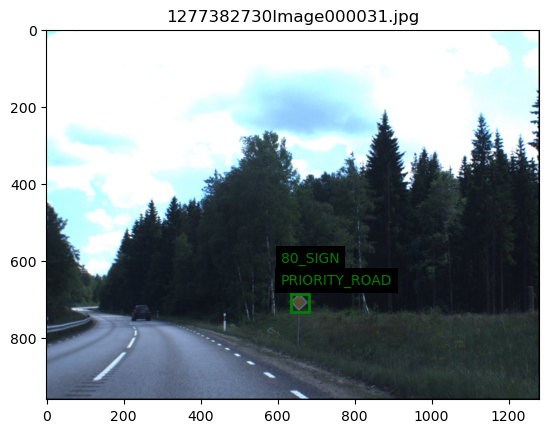

1277382730Image000031.jpg


In [98]:
# sample to show one image in the dataset, in here image number 132 as an example
fn = os.path.join(imagePath, content[132]['name'])
img = cv2.imread(fn)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(content[132]['name'])
display_signs(content[132]['signs'], options=1)
print(content[132]['name'])

In [200]:
# Your list of dictionaries to prepare the 
sign_data = []

# Iterate through the list of dictionaries and extract sign information
for item in content:
    for sign in item['signs']:
        sign_info = {
            'Image Name': item['name'],
            'label': sign.get('signTypes', None),
            'Sign Status': sign.get('signStatus', None),
            'Sign BB': sign.get('signBB', None),
            'Sign C': sign.get('signC', None),
            'Sign Size': sign.get('signSize', None),
            'Aspect Ratio': sign.get('aspectRatio', None)
        }
        sign_data.append(sign_info)

# Create a DataFrame from the list of sign information
df = pd.DataFrame(sign_data)
df.head()
# Display the DataFrame
print(df)

                     Image Name            label Sign Status  \
0     1277381655Image000002.jpg    PRIORITY_ROAD     BLURRED   
1     1277381655Image000007.jpg    PRIORITY_ROAD     BLURRED   
2     1277381655Image000012.jpg    PRIORITY_ROAD     VISIBLE   
3     1277381655Image000017.jpg    PRIORITY_ROAD     VISIBLE   
4     1277381655Image000022.jpg    PRIORITY_ROAD     VISIBLE   
...                         ...              ...         ...   
4408  1277391816Image000127.jpg       MISC_SIGNS         N/A   
4409  1277391816Image000127.jpg            OTHER     BLURRED   
4410  1277391816Image000127.jpg    PRIORITY_ROAD     BLURRED   
4411  1277391816Image000127.jpg  PASS_RIGHT_SIDE     BLURRED   
4412  1277391816Image000127.jpg  PASS_RIGHT_SIDE     BLURRED   

                                               Sign BB  \
0      [521.545082, 509.470324, 547.856366, 534.63764]   
1     [538.217824, 506.358141, 566.874451, 534.587056]   
2     [580.346221, 475.962085, 615.349298, 510.079008]   

1277382333Image000031.jpg


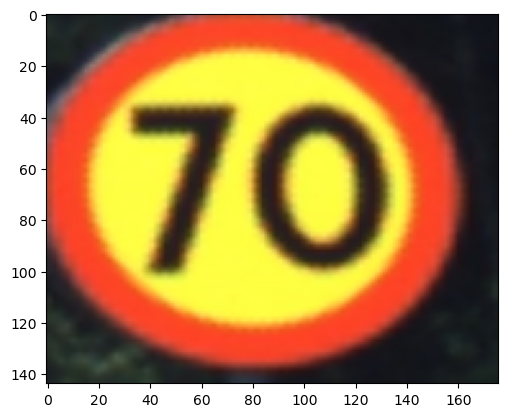

In [198]:
# crop one image save a copy of the resized image
image_number_sample = 112
fn = os.path.join(imagePath, df.loc[image_number_sample, 'Image Name'])
image_name = df.loc[image_number_sample, 'Image Name']
print(image_name)
img = cv2.imread(fn)
startX, startY, endX, endY = df.loc[image_number_sample, 'Sign BB']
cropped_img = img[math.floor(startY):math.ceil(endY), math.floor(startX):math.ceil(endX)]
plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
new_size = (176 , 144)
resized_img = cv2.resize(cropped_img, new_size)
plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
#address_resized = f"C:\\Mine\\Lund University\\IoT Machine learning\\Final project\\Resized_dataset\\{image_name}.jpg"
#cv2.imwrite(address_resized, resized_img) 

[array([[[130, 145, 147],
        [130, 145, 147],
        [130, 145, 147],
        ...,
        [255, 253, 255],
        [255, 253, 255],
        [255, 253, 255]],

       [[130, 145, 147],
        [130, 145, 147],
        [130, 145, 147],
        ...,
        [255, 253, 255],
        [255, 253, 255],
        [255, 253, 255]],

       [[130, 145, 146],
        [130, 145, 146],
        [130, 145, 146],
        ...,
        [255, 253, 255],
        [255, 253, 255],
        [255, 253, 255]],

       ...,

       [[ 48,  50,  52],
        [ 48,  50,  52],
        [ 48,  50,  52],
        ...,
        [140, 142, 121],
        [140, 142, 121],
        [140, 142, 121]],

       [[ 48,  50,  51],
        [ 48,  50,  51],
        [ 48,  50,  51],
        ...,
        [142, 145, 123],
        [142, 145, 123],
        [142, 145, 123]],

       [[ 48,  50,  51],
        [ 48,  50,  51],
        [ 48,  50,  51],
        ...,
        [142, 145, 123],
        [142, 145, 123],
        [142, 145, 123]

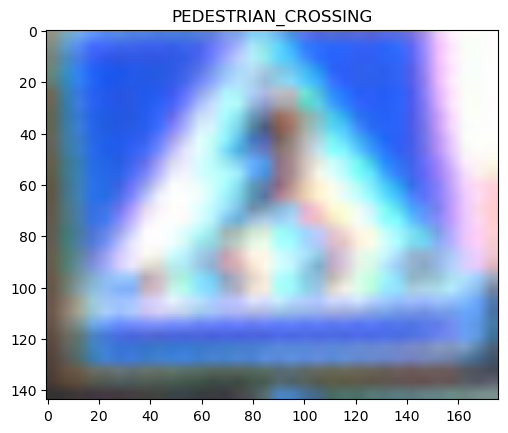

In [262]:
# generate x and y for only one sample to check if it is correct
image_number_sample = 3100
x = []
y = []
fn = os.path.join(imagePath, df.loc[image_number_sample, 'Image Name'])
image_name = df.loc[image_number_sample, 'Image Name']
img = cv2.imread(fn)
startX, startY, endX, endY = df.loc[image_number_sample, 'Sign BB']
cropped_img = img[math.floor(startY):math.ceil(endY), math.floor(startX):math.ceil(endX)]
new_size = (176 , 144)
resized_img = cv2.resize(cropped_img, new_size)
x.append(resized_img)
y.append(df.loc[image_number_sample, 'label'])
plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
plt.title(df.loc[image_number_sample, 'label'])
print(x)
print(y)
print(np.shape(x))
print(np.shape(y))

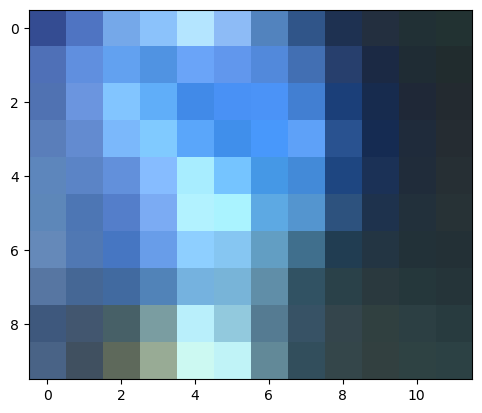

In [263]:
########## if you have already resized the database, do not run this cell

## crop all of the images in the database and save a copy of those resized images
x = []
y = []
for n in range(0,len(df)):
    fn = os.path.join(imagePath, df.loc[n, 'Image Name'])
    image_name = df.loc[n, 'Image Name']
    img = cv2.imread(fn)
    startX, startY, endX, endY = df.loc[n, 'Sign BB']
    if [startX, startY, endX, endY] == [-1, -1, -1, -1]:
        continue
    else:
        cropped_img = img[math.floor(startY):math.ceil(endY), math.floor(startX):math.ceil(endX)]
        plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
        new_size = (176 , 144)
        resized_img = cv2.resize(cropped_img, new_size)
        x.append(resized_img)
        y.append(df.loc[n, 'label'])

(3169, 144, 176, 3)
(3169,)


Text(0.5, 1.0, '70_SIGN')

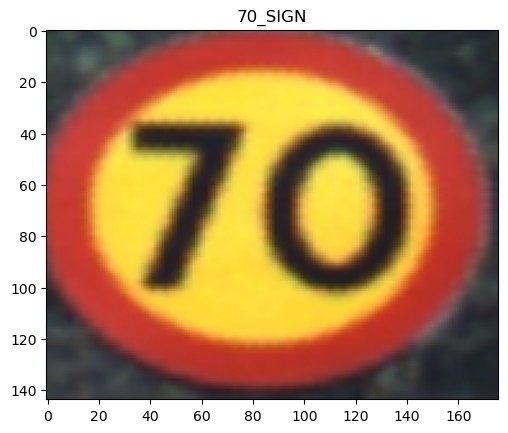

In [278]:
np.save('x.npy', x)
np.save('y.npy', y)
print(np.shape(x))
print(np.shape(y))
plt.imshow(cv2.cvtColor(x[1401], cv2.COLOR_BGR2RGB))
plt.title(y[1401])